## 蒙特卡洛方法
蒙特卡洛方法可以理解为算法完成一个回合之后，再利用这个回合的数据去学习，做一次更新。因为我们已经获得了整个回合的数据，所以也能够获得每一个步骤的奖励，我们可以很方便地计算每个步骤的未来总奖励，即回报$G_t$ 。$G_t$ 是未来总奖励，代表从这个步骤开始，我们能获得的奖励之和。$G_1$ 代表我们从第一步开始，往后能够获得的总奖励。$G_2$ 代表从第二步开始，往后能够获得的总奖励。相比蒙特卡洛方法一个回合更新一次，时序差分方法是每个步骤更新一次，即每走一步，更新一次，时序差分方法的更新频率更高。时序差分方法使用$Q$ 函数来近似地表示未来总奖励$G_t$。
![截屏2025-04-04 13.09.18.png](<attachment:截屏2025-04-04 13.09.18.png>)


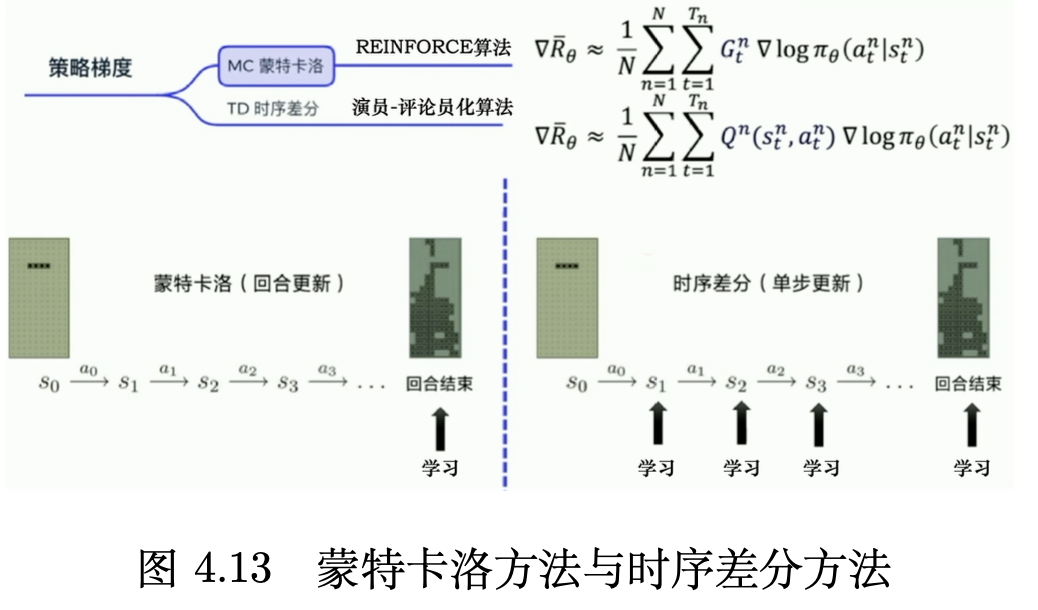

### 程序实现

#### 导入需要的包

In [66]:
import numpy as np
import math
import random
import gym
from collections import defaultdict
import sys
import os
import torch
import argparse
import matplotlib.pyplot as plt
import seaborn as sns


#### 定义算法

In [67]:
class FirstVisitMC:
    def __init__(self, cfg):
        self.n_actions = cfg.n_actions
        self.n_states = cfg.n_states
        self.epsilon = cfg.epsilon
        self.gamma = cfg.gamma
        self.Q_table = defaultdict(lambda: np.zeros(self.n_actions))
        self.returns_sum = defaultdict(float) # 保存return之和
        self.returns_count = defaultdict(float)
    
    def sample_action(self, state):
        state = str(state)
        if state in self.Q_table.keys():
            best_action = np.argmax(self.Q_table[state])
            action_prob = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
            action_prob[best_action] += (1.0 - self.epsilon)
            action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
        else:
            action = np.random.randint(0, self.n_actions)
        return action
    
    def predict_action(self, state):
        state = str(state)
        if state in self.Q_table.keys():
            best_action = np.argmax(self.Q_table[state])
            action_prob = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
            action_prob[best_action] += (1.0 - self.epsilon)
            action = np.argmax(self.Q_table[state])
        else:
            action = np.random.randint(0, self.n_actions)
        return action
    
    def update(self, one_ep_transition):
        sa_in_episode = set([(str(x[0]),x[1]) for x in one_ep_transition])
        for state, action in sa_in_episode:
            sa_pair = (state, action)

            first_occurence_idx = next(i for i, x in enumerate(one_ep_transition)
                                       if str(x[0]) == state and x[1] == action)
            G = sum([x[2] * (self.gamma ** i) for i, x in enumerate(one_ep_transition[first_occurence_idx:])])
            # 计算平均return
            self.returns_sum[sa_pair] += G
            self.returns_count[sa_pair] += 1.0
            self.Q_table[state][action] = self.returns_sum[sa_pair] / self.returns_count[sa_pair]


#### 定义训练

In [68]:
def train(cfg, env, agent):
    print(f"开始训练！")
    print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = []
    for i_ep in range(cfg.train_eps):
        ep_rewards = 0
        state = env.reset(seed=cfg.seed)
        one_ep_transition = []
        for _ in range(cfg.ep_max_steps):
            action = agent.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            one_ep_transition.append((state, action, reward))
            agent.update(one_ep_transition)
            state = next_state
            ep_rewards += reward
            if done:
                break
        rewards.append(ep_rewards)
        print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_rewards:.1f}，"
              f"奖励平均值：{np.mean(rewards[-10:]):.1f}，步数：{len(one_ep_transition)}")
    print("训练完成！")
    return {"rewards": rewards}

def test(cfg, env, agent):
    print(f"开始测试！")
    print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = []
    for i_ep in range(cfg.test_eps):
        ep_rewards = 0
        state = env.reset(seed=cfg.seed)
        for _ in range(cfg.ep_max_steps):
            action = agent.predict_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            ep_rewards += reward
            if done:
                break
        rewards.append(ep_rewards)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_rewards:.1f}")
    print("测试完成！")
    return {"rewards": rewards}


#### 定义环境

In [69]:
def all_seed(env,seed = 1):
    ''' omnipotent seed for RL, attention the position of seed function, you'd better put it just following the env create function
    '''
    if seed == 0:
        return
    # print(f"seed = {seed}")
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def env_agent_config(cfg):
    env = gym.make(cfg.env_name)
    all_seed(env,cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    cfg.n_states = n_states
    cfg.n_actions = n_actions
    agent = FirstVisitMC(cfg)
    return env,agent

#### 设置参数

In [70]:
def get_config():
    parser = argparse.ArgumentParser()
    parser.add_argument("--algo_name", default="Racetrack-v0", type=str, help="算法名称")
    parser.add_argument("--env_name", default="CartPole-v0", type=str, help="环境名称")
    parser.add_argument("--n_states", default=4, type=int, help="状态维度")
    parser.add_argument("--n_actions", default=2, type=int, help="动作维度")
    parser.add_argument("--train_eps", default=200, type=int, help="训练回合数")
    parser.add_argument("--test_eps", default=20, type=int, help="测试回合数")
    parser.add_argument("--ep_max_steps", default=100000, type=int, help="每个回合的最大步数")
    parser.add_argument("--epsilon", default=0.1, type=float, help="贪婪度")
    parser.add_argument("--lr", default=0.5, type=float, help="学习率")
    parser.add_argument("--gamma", default=0.9, type=float, help="折扣因子")
    parser.add_argument("--seed", default=1, type=int, help="随机种子")
    parser.add_argument("--device", default="cpu", type=str, help="cpu或者gpu")
    
    # 打印超参数
    args = parser.parse_args([])
    print("Hyperparameters:")
    print("".join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "value", "Type"))
    for k,v in vars(args).items():
        print(tplt.format(k, v, str(type(v))))
    print("".join(["="]*80))
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()


#### 开始训练

Hyperparameters:
        Name        	       value        	        Type        
     algo_name      	    Racetrack-v0    	   <class 'str'>    
      env_name      	    CartPole-v0     	   <class 'str'>    
      n_states      	         4          	   <class 'int'>    
     n_actions      	         2          	   <class 'int'>    
     train_eps      	        200         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
      epsilon       	        0.1         	  <class 'float'>   
         lr         	        0.5         	  <class 'float'>   
       gamma        	        0.9         	  <class 'float'>   
        seed        	         1          	   <class 'int'>    
       device       	        cpu         	   <class 'str'>    
开始训练！
环境：CartPole-v0, 算法：Racetrack-v0, 设备：cpu
回合：1/200，奖励：13.0，奖励平均值：13.0，步数：13
回合：2/200，奖励：13.0，奖励平均值：13.0，步数：13
回合：3/200，奖励：13.0，奖励平均值：13.0，步数：13
回合：4/200，奖励：22.0

TypeError: set_xlim() takes from 1 to 3 positional arguments but 4 were given

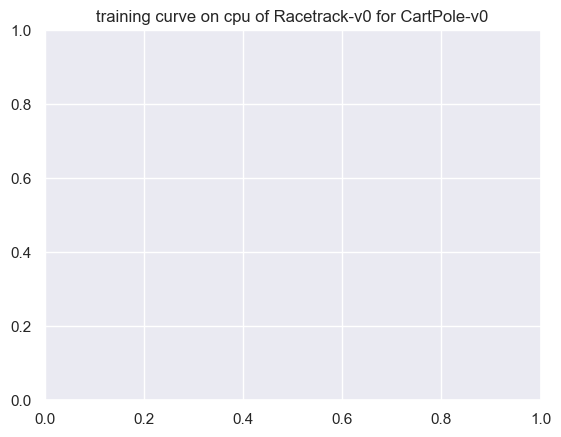

In [71]:
cfg = get_config()
env, agent = env_agent_config(cfg)
train_res = train(env=env, agent=agent, cfg=cfg)
plot_rewards(train_res["rewards"], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")

test_res = test(env=env, agent=agent, cfg=cfg)
plot_rewards(test_res["rewards"], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
